# Build an *ARMA* Predictive Time Series Model for Larcenies (WIP)
 _ this is a work in progress and needs further elaboration to be solid _

import python modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import statsmodels.api as sm
from math import sqrt
import seaborn as sns

set figure size

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

set seaborn style

In [3]:
sns.set_style("darkgrid")

# Load the data and clean

read the raw data set from CSV file

In [4]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv")

In [5]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


In [6]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [7]:
df.index = df['incident_dt']

# Extract larceny theft per month over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [8]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [9]:
larceny_incidents['incident_dt'].count()

27657

lets roll up the events up by month and study the pattern over time

In [10]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

traditionally in ML or stats we use a vector X to predict y

In [11]:
X = larceny_monthly_counts.rename('lar_cnts')

In [12]:
X.describe()

count    161.000000
mean     171.782609
std       41.954394
min       26.000000
25%      149.000000
50%      166.000000
75%      198.000000
max      286.000000
Name: lar_cnts, dtype: float64

In [13]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: lar_cnts, dtype: int64

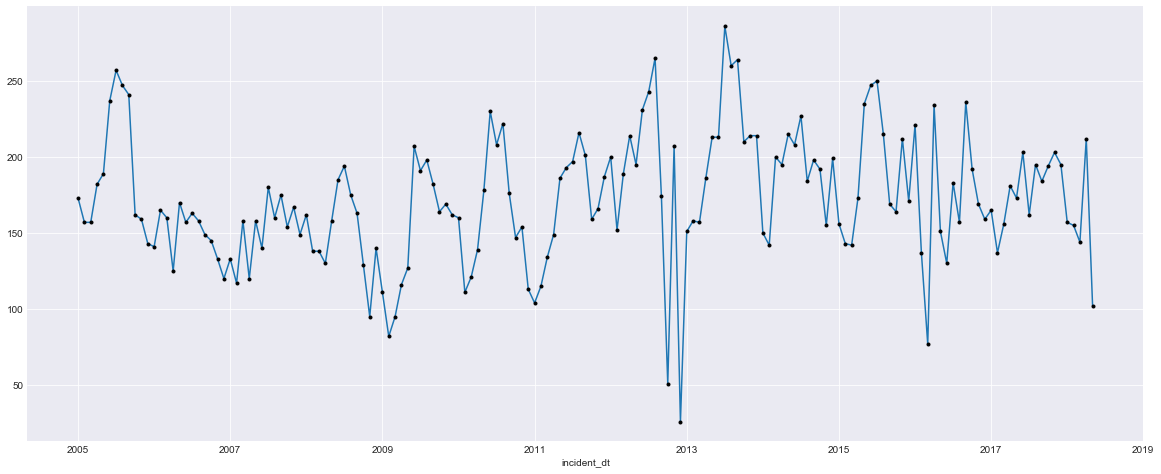

In [14]:
X.plot()
X.plot(style='k.', grid=True)

In [16]:
XD = X.diff(1)

In [22]:
XD.describe()

count    160.000000
mean      -0.443750
std       42.029601
min     -181.000000
25%      -19.250000
50%       -1.000000
75%       19.250000
max      157.000000
Name: lar_cnts, dtype: float64

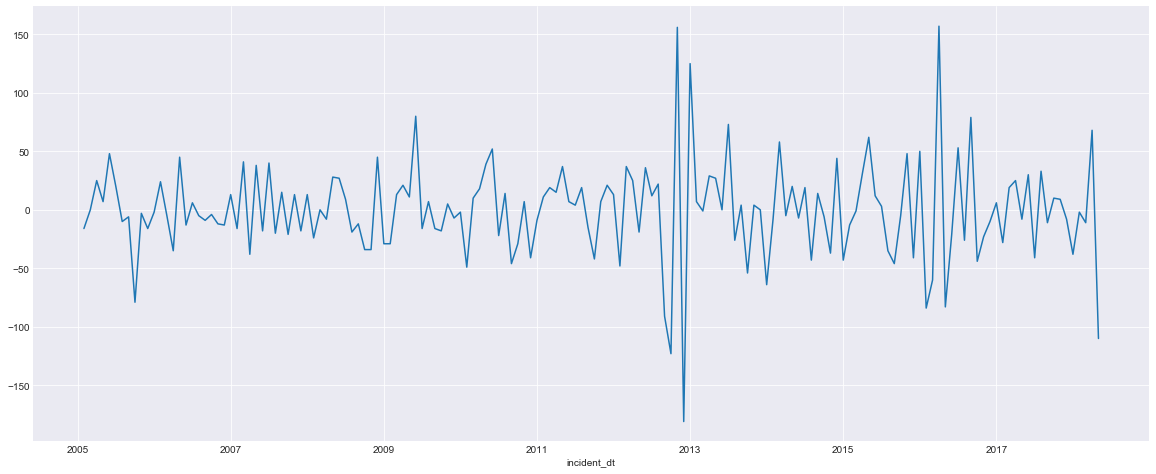

In [23]:
XD.plot()

## Section 1.1 Modeling the data with a time series analysis

lets build an ARMA model

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

lets look at the ACF and PACF for signs of seasonality

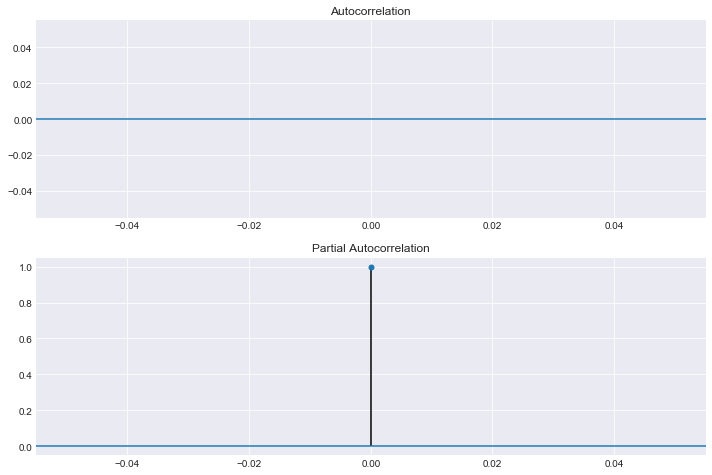

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(XD, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(XD, lags=20, ax=ax2)

*Looks like a seasonal effect right around 12 months*

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

statsmodels documentation suggests fitting an AR model to find the right lag 

In [16]:
model = sm.tsa.AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

Lag: 14


A lag of 14 months is our "magic" number. But 12 months makes more sense based on the domain

In [17]:
arma_mod1 = sm.tsa.ARMA(X, (14,1)).fit(disp=False)
arma_mod2 = sm.tsa.ARMA(X, (12,0)).fit(disp=False)

In [18]:
print(arma_mod1.aic, arma_mod1.bic, arma_mod1.hqic)
print(arma_mod2.aic, arma_mod2.bic, arma_mod2.hqic)

1611.3347141888041 1663.71858839354 1632.6046950771035
1607.5306332254668 1650.6702943352493 1625.0470880746545


In [19]:
predicted = arma_mod2.predict(150, 160, dynamic=True)
actual = X[150:160]
compare = pd.DataFrame(actual)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2017-07-31      162  192.883105  -30.883105     -19.063645
2017-08-31      195  192.065282    2.934718       1.504984
2017-09-30      184  198.495382  -14.495382      -7.877925
2017-10-31      194  181.962653   12.037347       6.204818
2017-11-30      203  179.962309   23.037691      11.348616
2017-12-31      195  170.786353   24.213647      12.417255
2018-01-31      157  160.071000   -3.071000      -1.956051
2018-02-28      155  162.436229   -7.436229      -4.797567
2018-03-31      144  159.966831  -15.966831     -11.088077
2018-04-30      212  167.720891   44.279109      20.886372


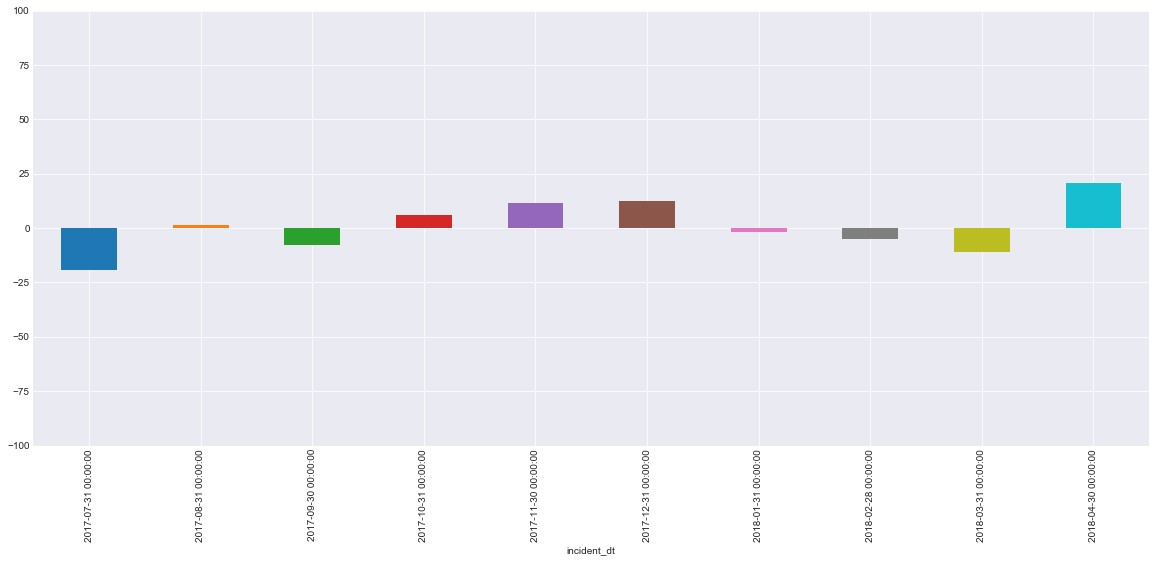

In [45]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')

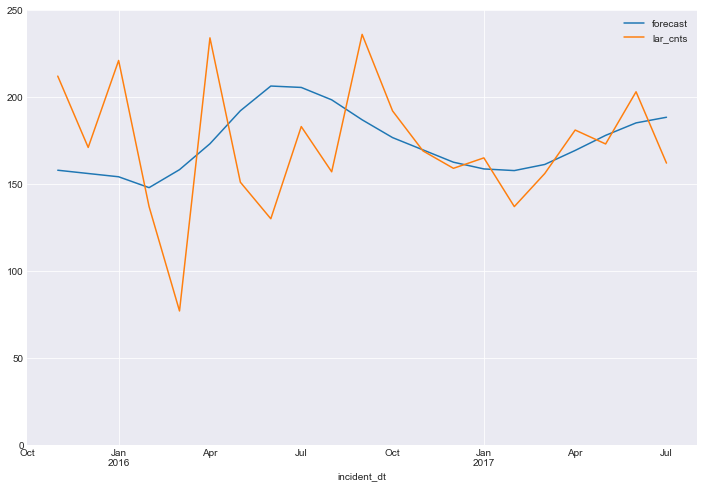

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax = X[150:].plot(ax=ax)
plt.ylim(0, 250)
fig = arma_mod2.plot_predict(130, 150, dynamic=True, ax=ax, plot_insample=True)

Lets do a thought experiment where we train the model on some number of months TM and use it to predict forward for some number of months PM

In [22]:
print("length of time series {}".format(len(X)))

length of time series 161


In [60]:
TM = 150 #train months
PM = 10 #predict months

In [61]:
train_size = TM
predict_size = PM
train, test = X[0:train_size], X[train_size:train_size + predict_size]
# using the 12 month model
predicted = arma_mod2.predict(train_size, train_size + predict_size, dynamic=True)

In [62]:
compare = pd.DataFrame(test)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2017-07-31      162  192.883105  -30.883105     -19.063645
2017-08-31      195  192.065282    2.934718       1.504984
2017-09-30      184  198.495382  -14.495382      -7.877925
2017-10-31      194  181.962653   12.037347       6.204818
2017-11-30      203  179.962309   23.037691      11.348616
2017-12-31      195  170.786353   24.213647      12.417255
2018-01-31      157  160.071000   -3.071000      -1.956051
2018-02-28      155  162.436229   -7.436229      -4.797567
2018-03-31      144  159.966831  -15.966831     -11.088077
2018-04-30      212  167.720891   44.279109      20.886372


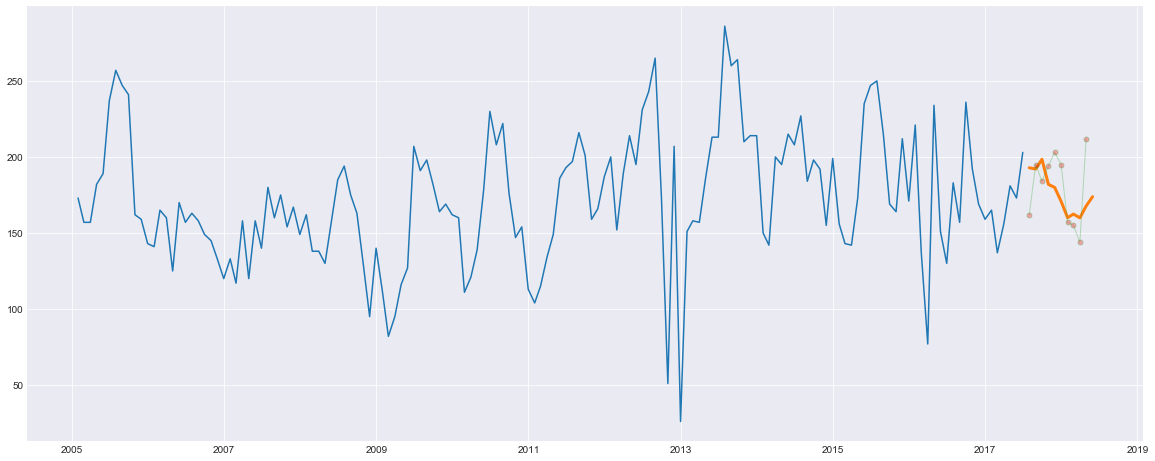

In [63]:
plt.plot(train)
plt.plot(predicted, lw=3.0)
plt.plot(test, '-o', ms=5, lw=1, alpha=0.3, mfc='red')

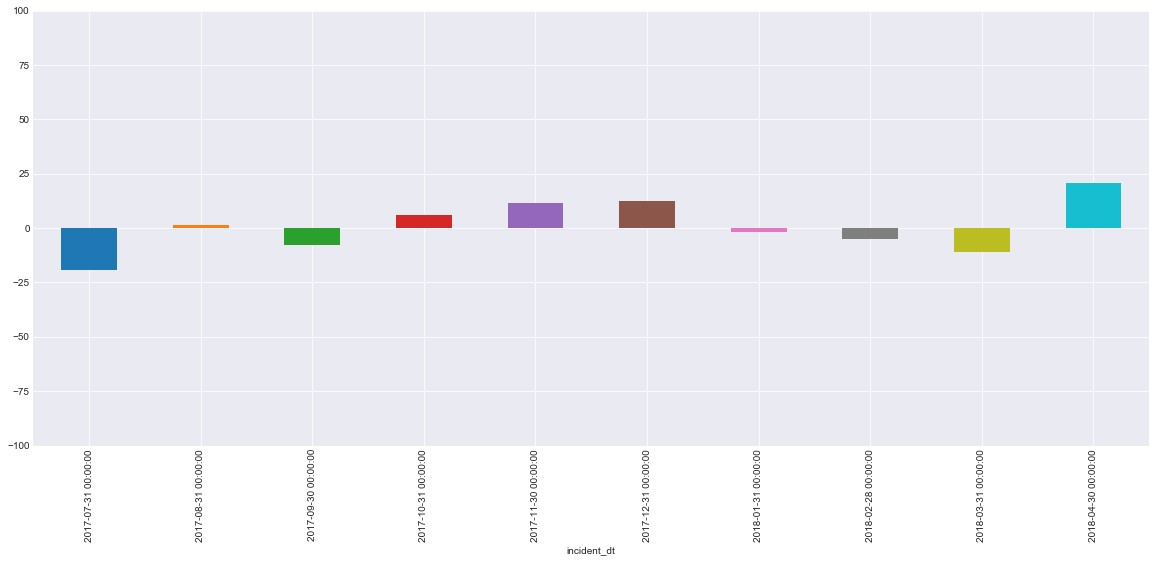

In [64]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')